Adithya Palle \
March 30, 2025 \
Final Project

Jupyter Notebook for training CNN and visualizing loss on validation as well as first convolutional layer.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using 100 images for training and testing.
Using device cpu
Number of parameters in the model: 1563929
Searching for jpg files in directory: data/Fire_Detection.v1.coco/train/
Found 8939 jpg files in directory: data/Fire_Detection.v1.coco/train/
Number of fire images: 50
Number of no fire images: 50
Searching for jpg files in directory: data/data_256
Found 1803460 jpg files in directory: data/data_256
80 samples used in training
10 samples used in val
10 samples used in test


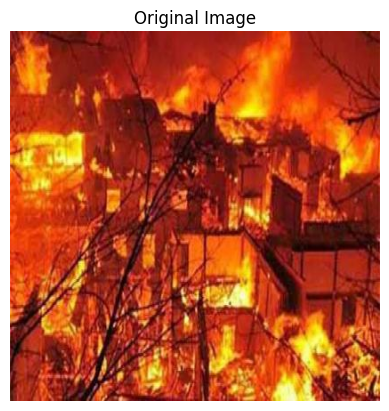

In [8]:

from train_cnn import TrainingModel, train_cnn, ModelWithTransform, visualize_loss_curve, visualize_layer_weights, TrainingParameters
from data_extraction import get_image_data, preprocess_data, TRANSFORM
import torch
import matplotlib.pyplot as plt
n_samples = 100
MODEL_NAME = "silly_test"
output_file_path = f"{MODEL_NAME}.pth"

print(f"Using {n_samples} images for training and testing.")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device {DEVICE}")
model = TrainingModel()

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
training_params = TrainingParameters(
        optimizer=optim,
        loss_function=torch.nn.BCEWithLogitsLoss(), # Binary Classification Loss that automatically applies sigmoid
        batch_size=128,
        n_epochs=15,
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', patience=5, factor=0.5), # reduce learning reate by half if no improvement in 5 epochs
        early_stopping_threshold=1e-5,
        device = DEVICE
    )

# resize to 224x224 as preprocessing step
model_and_transform = ModelWithTransform(model, TRANSFORM)

all_image_data= get_image_data(n_samples)
train,val,test = preprocess_data(all_image_data)

print(f"{len(train)} samples used in training")
print(f"{len(val)} samples used in val")
print(f"{len(test)} samples used in test")


random_fire_img = None
for i in range(0, len(train)):
    if all_image_data[i][1]:
        random_fire_img = all_image_data[i][0]
        break

if random_fire_img is None:
    raise ValueError("No fire image found in the training set.")


# show original image
plt.imshow(random_fire_img.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')
plt.title("Original Image")
plt.show()




In [9]:

train_loss, val_loss ,fire_detector = train_cnn(model_and_transform,training_params,train, val)
# Save the trained model to a file
fire_detector.save_to_file(output_file_path)
print(f"Model saved to {output_file_path}")
# save data for later evaluation
val.save(f"data/tensor_cache/{MODEL_NAME}_val")
test.save(f"data/tensor_cache/{MODEL_NAME}_test")


Begin training...
Epoch 1 completed. Train loss: 0.6984, Validation loss: 0.7078
Epoch 2 completed. Train loss: 0.6879, Validation loss: 0.7153
Epoch 3 completed. Train loss: 0.6617, Validation loss: 0.7110
Epoch 4 completed. Train loss: 0.6721, Validation loss: 0.6994
Epoch 5 completed. Train loss: 0.6892, Validation loss: 0.6942
Epoch 6 completed. Train loss: 0.6789, Validation loss: 0.6907
Epoch 7 completed. Train loss: 0.6850, Validation loss: 0.6889
Epoch 8 completed. Train loss: 0.6828, Validation loss: 0.6848
Epoch 9 completed. Train loss: 0.6688, Validation loss: 0.6736
Epoch 10 completed. Train loss: 0.6523, Validation loss: 0.6514
Epoch 11 completed. Train loss: 0.6271, Validation loss: 0.6312
Epoch 12 completed. Train loss: 0.6451, Validation loss: 0.6153
Epoch 13 completed. Train loss: 0.6826, Validation loss: 0.6190
Epoch 14 completed. Train loss: 0.6146, Validation loss: 0.6286
Epoch 15 completed. Train loss: 0.6181, Validation loss: 0.6350
Model saved to silly_test.pth


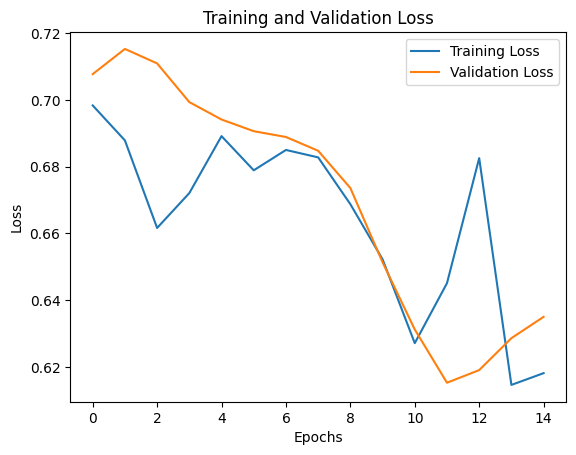

In [10]:
visualize_loss_curve(train_loss, val_loss)



Filters shape:  torch.Size([16, 3, 5, 5])
torch.Size([16, 3, 5, 5])


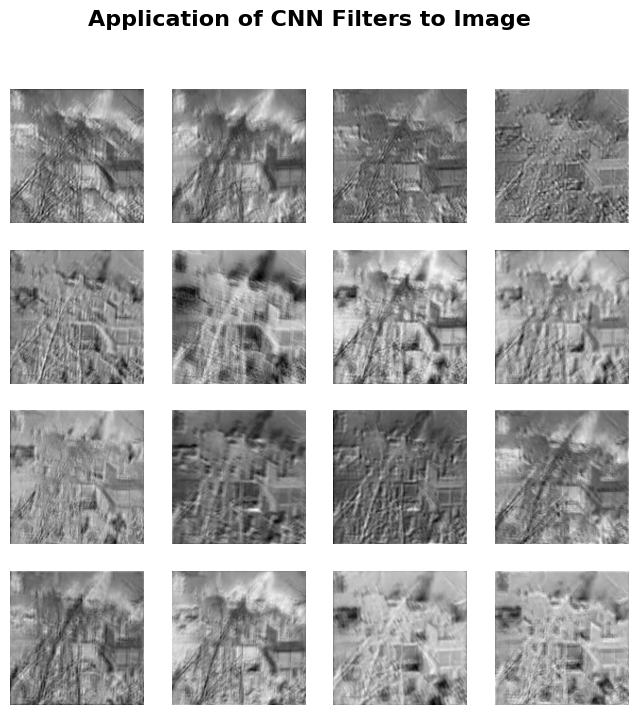

In [11]:
random_fire_img = TRANSFORM(random_fire_img) # apply preprocessing
visualize_layer_weights(fire_detector.model.trained_model.convolutional_layers[0], random_fire_img)


In [12]:
# TODO: save test tensors to tensor_cahce and run inferneceo ntehm  to test recall/fpr on unseen image data
# use VAL images to get decision threshold